Dimensiuni train: (4274, 11)   test: (5687, 11)
Clase unice în y_train: [0 1 2]
Etichete unice în y_train: [0 1 2]
{0: 2381, 1: 1887, 2: 6}

Etichete unice în y_test: [0 1]
{0: 3674, 1: 2013}
C=0.03125, γ=3.0517578125e-05 → F1_weighted=0.2134 ± 0.1805
C=0.03125, γ=0.0001220703125 → F1_weighted=0.2134 ± 0.1805
C=0.03125, γ=0.00048828125 → F1_weighted=0.2134 ± 0.1805
C=0.03125, γ=0.001953125 → F1_weighted=0.3784 ± 0.0453
C=0.03125, γ=0.0078125 → F1_weighted=0.5376 ± 0.0312
C=0.03125, γ=0.03125 → F1_weighted=0.6483 ± 0.0644
C=0.03125, γ=0.125 → F1_weighted=0.6773 ± 0.0731
C=0.03125, γ=0.5 → F1_weighted=0.5761 ± 0.1548
C=0.03125, γ=1 → F1_weighted=0.3727 ± 0.0514
C=0.03125, γ=2 → F1_weighted=0.3727 ± 0.0514
C=0.03125, γ=3 → F1_weighted=0.3727 ± 0.0514
C=0.03125, γ=4 → F1_weighted=0.3727 ± 0.0514
C=0.03125, γ=5 → F1_weighted=0.3727 ± 0.0514
C=0.03125, γ=8 → F1_weighted=0.3727 ± 0.0514
C=0.03125, γ=16 → F1_weighted=0.3727 ± 0.0514
C=0.125, γ=3.0517578125e-05 → F1_weighted=0.2134 ± 0.1805
C=0

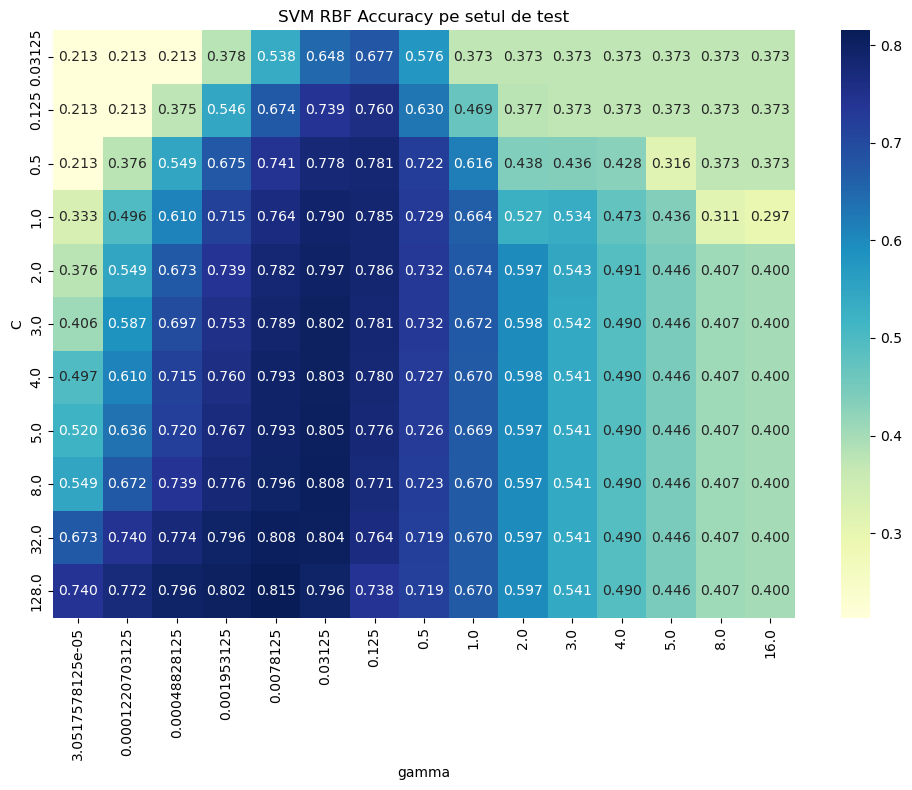

Test accuracy: 0.8800773694390716
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      3674
           1       0.82      0.84      0.83      2013
           2       0.00      0.00      0.00         0

    accuracy                           0.88      5687
   macro avg       0.58      0.58      0.58      5687
weighted avg       0.88      0.88      0.88      5687



In [2]:
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

train_df = pd.read_csv("ae_train.csv")
test_df  = pd.read_csv("ae_test.csv")

X_train = train_df.iloc[:, 1:].values
y_train = train_df.iloc[:, 0].astype(int).values

X_test  = test_df.iloc[:, 1:].values
y_test  = test_df.iloc[:, 0].astype(int).values

print("Dimensiuni train:", X_train.shape, "  test:", X_test.shape)
print("Clase unice în y_train:", np.unique(y_train))

print("Etichete unice în y_train:", np.unique(y_train))
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))

print("\nEtichete unice în y_test:", np.unique(y_test))
unique, counts = np.unique(y_test, return_counts=True)
print(dict(zip(unique, counts)))

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

Cost  = [2**-5, 2**-3, 2**-1, 1, 2, 3, 4, 5, 2**3, 2**5, 2**7]
Gamma = [2**-15, 2**-13, 2**-11, 2**-9, 2**-7, 2**-5, 2**-3, 2**-1, 1, 2**1, 3, 4, 5, 2**3, 2**4]

best_f1 = 0
best_params_f1 = {'C': None, 'gamma': None}
results = []

for C in Cost:
    for g in Gamma:
        clf = svm.SVC(kernel='rbf', C=C, gamma=g, class_weight='balanced')
        scores = cross_val_score(clf, X_train_scaled, y_train, cv=5, scoring='f1_weighted', n_jobs=-1)
        mean_f1 = scores.mean()
        results.append({'C': C, 'gamma': g, 'f1_weighted': mean_f1})
        if mean_f1 > best_f1:
            best_f1 = mean_f1
            best_params_f1 = {'C': C, 'gamma': g}
        print(f"C={C}, γ={g} → F1_weighted={mean_f1:.4f} ± {scores.std():.4f}")

print(f"\n=== Best F1_weighted: {best_f1:.4f} at C={best_params_f1['C']}, γ={best_params_f1['gamma']} ===")

res_df = pd.DataFrame(results)
pivot = res_df.pivot(index='C', columns='gamma', values='f1_weighted')

plt.figure(figsize=(10, 8))
sns.heatmap(pivot, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("SVM RBF Accuracy pe setul de test")
plt.xlabel("gamma")
plt.ylabel("C")
plt.tight_layout()
plt.show()

clf_final = svm.SVC(kernel='rbf', C=best_params_f1['C'], gamma=best_params_f1['gamma'], class_weight='balanced')
clf_final.fit(X_train_scaled, y_train)
y_test_pred = clf_final.predict(X_test_scaled)

print("Test accuracy:", accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred, zero_division=0))
